In [1]:
import os
import shutil
from IPython.display import display, Image as DImage

import numpy
from numpy import array
from PIL import Image, ImageDraw


ncc_mode = True

width = 10
string_mode = True
top = 3
empty_threshold = 65
threshold = 3
delete_threshold = 200
bin_ratio = 600

binary_path = os.getcwd() + '/binary/'
found_path = os.getcwd() + '/found/'
cutted_path = os.getcwd() + '/cutted/'

bin_examples = []
names = []
nccors = []
results = []

RESULT = ''

In [2]:
def UI():
    global input_address, examples_path
    
    input_address = input('Input image address (default is test.png) :')
    imput_address = '\''+ input_address + '\''
    if input_address == '': input_address = 'test.png'

    examples_path = input('Input path to folder with samples (default is /examples/):')
    examples_path = '\''+ examples_path + '\''
    examples_path = os.getcwd() + '/examples/'
    
    erase_flag = input('Clear examples after the previous preprocessing? [y/N]:')
    #erase_flag = '\''+ erase_flag + '\''
    return erase_flag

In [3]:
def create_folders():
    global examples_path, binary_path, found_path, cutted_path
    if not os.path.exists(examples_path):
        os.mkdir('examples')
        examples_path = os.getcwd() + '/examples/'

    if not os.path.exists(binary_path):
        os.mkdir('binary')
        binary_path = os.getcwd() + '/binary/'

    if not os.path.exists(found_path):
        os.mkdir('found')
        found_path = os.getcwd() + '/found/'
    
    if not os.path.exists(cutted_path):
        os.mkdir('cutted')
        cutted_path = os.getcwd() + '/cutted/'

    for d, dirs, files in os.walk(examples_path):
            for f in dirs:
                if not os.path.exists(binary_path + f):
                    os.mkdir(binary_path+ f)
                    os.mkdir(cutted_path+ f)

In [4]:
def clean_folders():              
    if os.path.exists(binary_path):   
        shutil.rmtree(binary_path)
    
    if os.path.exists(found_path):
        shutil.rmtree(found_path)
        
    if os.path.exists(cutted_path):
        shutil.rmtree(cutted_path)

In [5]:
def address_helper(addr, mode):
    if mode == 'png': #after preprocessing the program only works with .png
        addr = addr[:-4]+'.png' 
        
    if mode == 'bin': #change the address of the folder to /binary
        addr = addr.replace('/examples/', '/binary/')
        
    if mode == 'cln': #leave only the name of file (letter)
        addr = addr[:-4]
        addr = addr.replace(binary_path, '')
        addr = addr.replace(found_path, '')
        addr = addr.replace(cutted_path, '')
    
    return addr

In [6]:
def binarization(input_img_addr):
    input_image  = Image.open(input_img_addr).convert('RGBA') #convert for .gif opening fix
    draw = ImageDraw.Draw(input_image)
     
    for i in range(input_image.size[0]):
        for j in range(input_image.size[1]):
            r, g, b, a = input_image.getpixel((i, j))
            if a == 0:
                r, g, b = 0, 0, 0
            if (r + g + b > bin_ratio): 
                r, g, b = 255, 255, 255
            else:
                r, g, b = 0, 0, 0 
            draw.point((i, j), (r, g, b))
    del draw
    
    input_img_addr = address_helper(input_img_addr, 'png')
    input_image.save(address_helper(input_img_addr, 'bin'), "PNG")

In [7]:
def separation(input_img_addr, threshold, empty_threshold):
    x0 = 0
    y0 = 0
    x1 = 0
    y1 = 0

    symbolsx = []
    symbolsy = []

    black = 0
    symbol = False
    empty = 0
    
    input_image = Image.open(input_img_addr).convert('L')
    
    for x in range(input_image.size[0]):
        for y in range(input_image.size[1]):
            pix = input_image.getpixel((x, y))
            if pix < 255:
                black += 1
        if symbol == True and black < threshold:
            empty += 1
        if symbol == False and black > threshold: 
            x0 = x
            symbol = True
        if symbol == True and black <= threshold and empty >= empty_threshold:
            x1 = x
            symbol = False
            symbolsx.append((x0, x1))
            empty = 0
        black = 0
    
    
    black = 0
    symbol = False
    
    if string_mode:
        for y in range(input_image.size[1]):
            for x in range(input_image.size[0]):
                pix = input_image.getpixel((x, y))
                if pix < 255:
                    black += 1
            if symbol == True and black < threshold:
                empty += 1
            if symbol == False and black > threshold:
                y0 = y
                symbol = True
            if symbol == True and black <= threshold and empty >= empty_threshold:
                y1 = y
                symbol = False
                symbolsy.append((y0, y1))
                empty = 0
            black = 0
    
    count = 0
    black = 0
    
    if symbolsx == []:
        symbolsx = [(0, input_image.size[0])] 
    if symbolsy == []:
        symbolsy = [(0, input_image.size[1])] 
        
    for y in symbolsy:
        for x in symbolsx:
            if count < 1000:
                temp = '{:03d}'.format(count)
                addr = 'found/' + str(temp) + '.png'
                input_image.crop((x[0], y[0], x[1], y[1])).save(addr, "PNG")
            count += 1

In [8]:
def delete_trash(threshold):
    images = os.listdir(found_path)
    for i in range(len(images)):
        try:
            black = 0
            input_image = Image.open(found_path + images[i])
            
            for x in range(input_image.size[0]):
                for y in range(input_image.size[1]):
                    pix = input_image.getpixel((x, y))
                    if pix != 255:
                        black += 1
            if black < threshold:
                os.remove(found_path + images[i])
        except IOError:
            pass        

In [9]:
def ncc(input_img_addr, example_addr): 
    global width
    input_image = Image.open(input_img_addr)
    wpercent = (width / float(input_image.size[0]))
    height = int((float(input_image.size[1]) * float(wpercent)))
    input_image = input_image.resize((width,height),Image.ANTIALIAS)
    example = Image.open(example_addr).resize((input_image.size[0],
                                               input_image.size[1]), 
                                              Image.ANTIALIAS)
    
    images = [input_image, example]
    vectors = []
    norms = []
    for image in images:
        vector = []
        for pixel in image.getdata():
            vector.append(numpy.mean(pixel))
        vectors.append(vector)
        norms.append(numpy.linalg.norm(vector, 2))
    a, b = vectors
    a_norm, b_norm = norms
    res = numpy.dot(a / a_norm, b / b_norm)
    return res

In [10]:
def compare_1to1(input_img_addr, example_addr):
    input_img_addr = found_path + input_img_addr
    naive_cut(input_img_addr)

    if ncc_mode:
        nccors.append(ncc(input_img_addr, example_addr))
    
    names.append(address_helper(example_addr, 'cln')) 

In [11]:
def compare_1toN(input_img_addr):
    global names, nccors, bin_examples
    names, nccors = [], []
    
    for i in range(len(bin_examples)):
        try:
            compare_1to1(input_img_addr, bin_examples[i])
        except IOError:
            pass

In [12]:
def result_1toN():
    global results
    global RESULT
    results = []
    
    if ncc_mode and nccors != []:
        results.append(names[nccors.index(max(nccors))])
    
    if results == []:
        results = ['']
        
    temp = max(set(results), key=results.count)
    display(DImage(filename=binary_path + temp + '.png'))
    for d, dirs, files in os.walk(examples_path):
        for f in dirs:
            temp = temp.replace(f, '')
            temp = temp.replace('/', '')  
    RESULT += temp 

In [13]:
def print_full(top, tmp_arr, flag):
    for i in range(top):
        if flag == 'max':
            tmp = max(tmp_arr)
        if flag == 'min':
            tmp = min(tmp_arr)    
        print(str(i+1)+". :"+str(names[tmp_arr.index(max(tmp_arr))])+" scores: "+str(max(tmp_arr)))
        tmp_arr.remove(max(tmp_arr))

In [14]:
def print_1toN():
    global top
    print('Results:')
    if ncc_mode and nccors != []:
        print('NCC mode:')
        print_full(top, nccors, 'max')
    print('Result:' + str(RESULT))

In [15]:
def naive_cut(img_address):
    img = Image.open(img_address).convert('L')
    arr = array(img)
    norm_arr = []
    find = False

    for c in range(4):
        black = 0
        find = False
        img = Image.fromarray(arr)
        for x in range(len(arr[:, 1])):
            if find:
                break
            for y in range(len(arr[1, :])):
                if arr[x, y] == 0:
                    black += 1
            if black >= 1:
                arr = numpy.delete(arr, numpy.s_[0:x], axis=0)
                find = True
                break
        arr = numpy.rot90(arr)
        c+=1
        
    
    img = Image.fromarray(arr)
    img.save(img_address.replace('binary', 'cutted'),"PNG")

In [16]:
def found_symbols():
    symbols = os.listdir(found_path)
    print('Found:')
    for i in sorted(symbols):
        try:
            display(DImage(filename=found_path + i))
        except IOError:
            pass

In [17]:
def main():
    erase_flag = UI()
    global RESULT, input_address, empty_threshold, bin_examples
    RESULT = ''
    try:
        binarization(input_address)
    except IOError:
        print('Error. Input image is not found.')
        return 0
    display(DImage(filename=input_address[:-4]+'.png'))
    input_address = address_helper(input_address, 'png')
    
    if erase_flag == 'y' or erase_flag == 'Y' or not os.path.exists(binary_path):
        clean_folders()
        create_folders()
        examples = []
        for d, dirs, files in os.walk(examples_path):
            for f in files:
                path = os.path.join(d, f)
                examples.append(path)

        for i in range(len(examples)):
            try:
                binarization(examples[i])
                naive_cut(address_helper(examples[i], 'bin'))
            except IOError:
                pass

        
        for d, dirs, files in os.walk(cutted_path):
            for f in files:
                path = os.path.join(d, f)
                bin_examples.append(path)
    else:                
        if os.path.exists(found_path):
            shutil.rmtree(found_path)
        create_folders()
        
        for d, dirs, files in os.walk(cutted_path):
            for f in files:
                path = os.path.join(d, f)
                bin_examples.append(path)
            
   
    separation(input_address, threshold, empty_threshold)
    delete_trash(delete_threshold)
        
    symbols = os.listdir(found_path)
    count = 0 
    for i in sorted(symbols):
        try:
            count += 1
            print('Processing:')
            display(DImage(filename=found_path + i))
            compare_1toN(i)
            result_1toN()
            print_1toN()
            print('Processed: ' + str(count) + '/' + str(len(symbols)))
        except IOError:
            pass
    print('Message: ' + RESULT)
    RESULT = ''

Input image address (default is test.png) :
Input path to folder with samples (default is /examples/):
Clear examples after the previous preprocessing? [y/N]:


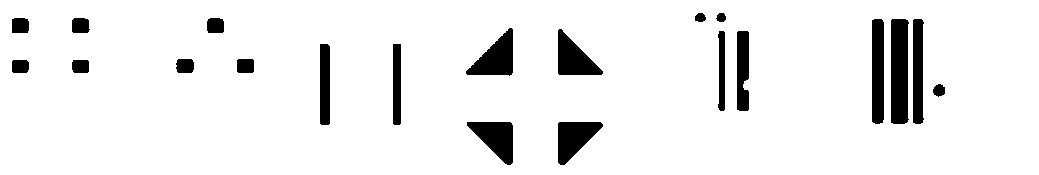

Processing:


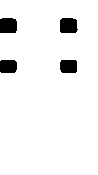

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


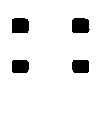

Results:
NCC mode:
1. :27/r scores: 1.0
2. :8/v scores: 0.956614283983
3. :28/j scores: 0.947410074388
Result:r
Processed: 1/6
Processing:


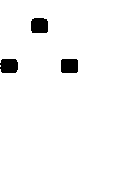

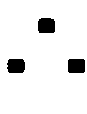

Results:
NCC mode:
1. :27/w scores: 1.0
2. :8/b scores: 0.957318814071
3. :10/t scores: 0.950612860436
Result:rw
Processed: 2/6
Processing:


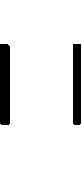

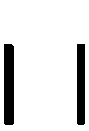

Results:
NCC mode:
1. :16/h scores: 1.0
2. :29/e scores: 0.970247548199
3. :29/h scores: 0.966251171209
Result:rwh
Processed: 3/6
Processing:


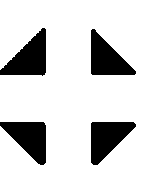

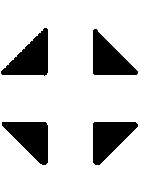

Results:
NCC mode:
1. :22/z scores: 0.999734061817
2. :25/d scores: 0.927934958682
3. :25/a scores: 0.920559372392
Result:rwhz
Processed: 4/6
Processing:


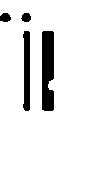

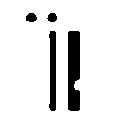

Results:
NCC mode:
1. :13/y scores: 1.0
2. :12/q scores: 0.898973695979
3. :14/w scores: 0.888472136036
Result:rwhzy
Processed: 5/6
Processing:


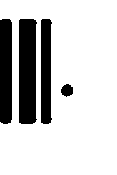

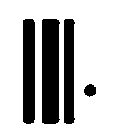

Results:
NCC mode:
1. :13/o scores: 1.0
2. :29/r scores: 0.791053159537
3. :29/uv scores: 0.790417983781
Result:rwhzyo
Processed: 6/6
Message: rwhzyo


In [18]:
main()